In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import concurrent.futures

We take the H matrix as below.  

In [3]:
H = np.loadtxt("Hmatrix1.txt",delimiter=',')

We define the function to make adjacency list.

In [4]:
def ADJList(H):
    adjList = []
    
    for i in range(0,len(H)):
        temp = []
        for j in range(0,len(H[0])):
            if H[i][j] == 1:
                temp.append(j)
        adjList.append(temp)

    return adjList

In [5]:
# Make the adjacency list for CN and VN
adjListCN = ADJList(H)
adjListVN = ADJList(np.transpose(H))

# print("Adjajency list for Check Nodes: ", adjListCN)
# print("Adjajency list for Variable Nodes: ", adjListVN)

Now, iterate through this adjacency lists to correct the received codeword.

In [6]:
def LDPC_Decoder(received):
    for _ in range(0, 20): # Total 25 iterations
        for var_node in range(len(H[0])): # Run loop for each Variable Node
            for j in adjListVN[var_node]: # Check for each Check Node connected to that Variable Node
                temp = [] 
            
                for var in adjListCN[j]: # For Variable Nodes connected to current Check Node
                    # Append the value of Variable Nodes into temp list other than current Variable Node
                    if var != var_node:
                        temp.append(received[var])
                # print(temp) 
                
                for val in temp:
                    flag = 0
                    # If any of the temp value is -1, we can't update received bit
                    if val == -1:
                        flag = 1    
                        break
                
                # If no bit is -1, update received bit (which has erased value -1) to sum % 2
                if flag == 0 and received[var_node] == -1:
                    received[var_node] = np.sum(temp) % 2
        
    return received
    

Check for any input received bits

In [7]:
# global p_psd
# p_psd = dict() # Probab_psd dict
def simulate_bec_monte_carlo_parallel(p, Nsim=300):
    n = H.shape[1]
    m = H.shape[0]

    F = np.zeros(Nsim) #Flag
    
    for l in range(Nsim):
        # Generate random codeword and transmit over BEC
        x = np.random.randint(0, 1, size=n)
        r = x.copy() # n elements
        r[np.random.rand(n) < p] = -1 #-1 -> Erasure bits

        # Decode received signal
        x_dec = LDPC_Decoder(r)

        # Check if decoding was successful
        if np.all(x_dec == x):
            F[l] = 1

    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     futures = [executor.submit(simulate, l) for l in range(Nsim)]
    
    psd = np.mean(F) #probability of successful decoding
    # global p_psd
    # p_psd[p] = psd
    return psd

#Usage:
p_values = np.arange(0, 1.01, 0.08)
# p_values = np.array([0.12,0.25,0.38,0.41,0.55,0.69,0.72,0.82,0.92,0.99,1.0])
pe_values = [simulate_bec_monte_carlo_parallel(p) for p in p_values] #Prob of error

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(simulate_bec_monte_carlo_parallel, p) for p in p_values]

# for future in concurrent.futures.as_completed(futures):
#     pe_values.append(future.result())


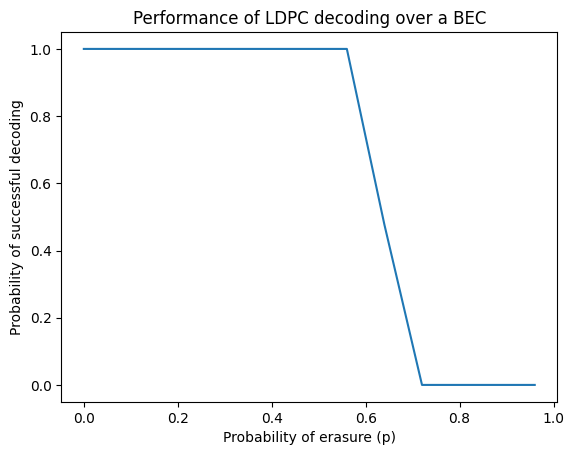

In [8]:
# for p in p_values:
#     pe_values.append(p_psd[p])

plt.plot(p_values, pe_values)
plt.xlabel("Probability of erasure (p)")
plt.ylabel("Probability of successful decoding")
plt.title("Performance of LDPC decoding over a BEC")
plt.show()